<a id="2"></a>
# Modeling the Results of Pulls for SSR+ Shards Using Monte Carlo Simulations
Credit to **VoidTwo** (_voidtwo on Discord_) for writing the code<br>
Report written by Nillabutt<br>
February 8, 2024

[*jump to the tables*](#1)

In [1]:
# Future imports
from __future__ import annotations

# Standard imports
from collections import defaultdict
from multiprocessing.pool import Pool as mp_Pool
from secrets import randbelow as secrets_randbelow
from typing import TYPE_CHECKING

# 3rd party imports
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

from jupyterthemes import jtplot
jtplot.style(theme='onedork', context='notebook', ticks=True, grid=False)

In [2]:
# Type checking
if TYPE_CHECKING:
    from typing import (
        ClassVar,
        Final)

    from matplotlib.axes import Axes

In [3]:
class SummonInfo:
    shard_probability_range: ClassVar[int] = 100_000
    shard_probability_threshold: ClassVar[dict[int, int]] = {
        1: 18_000,  # 18.000%
        2: 23_500,  # 5.500%
        5: 25_500}  # 2.000%
    shard_probability_order: ClassVar[tuple[int, ...]] = (
        1, 2, 5)

    shard_pities: ClassVar[dict[int, int]] = {
        1: 7,
        2: 20,
        5: 55}
    shard_pity_floors: ClassVar[dict[int, int]] = {
        1: 7,
        2: 19,
        5: 48}
    shard_pity_priority: ClassVar[tuple[int, ...]] = (
        5, 2, 1)

    shard_goal: ClassVar[int] = 205

    __slots__: tuple[str, ...] = ()

    def __init__(self) -> None:
        return


class SummonProgress:
    __slots__: tuple[str, ...] = (
        '__pity_counts',
        '__accumulated_shards')

    def __init__(self) -> None:
        shard_count: int
        self.__pity_counts: Final[dict[int, int]] = dict(
            (shard_count, 1) for shard_count in SummonInfo.shard_pity_priority)
        self.__accumulated_shards: int = 0
        return

    def __str__(self) -> str:
        return (
            f'__pity_counts: {self.__pity_counts}\n'
            f'__accumulated_shards: {self.__accumulated_shards}')

    @property
    def accumulated_shards(self) -> int:
        return self.__accumulated_shards

    def add_shards(self, shard_count: int) -> None:
        self.__accumulated_shards += shard_count
        return

    def get_pity_count(self, shard_count: int) -> int:
        return self.__pity_counts[shard_count]

    def add_pity(self, shard_count: int) -> None:
        self.__pity_counts[shard_count] += 1
        return

    def reset_pity(self, shard_count: int) -> None:
        self.__pity_counts[shard_count] = 1
        return

In [4]:
def simulate_summon(summon_progress: SummonProgress) -> None:
    add_shards: int = 0
    shard_count: int

    for shard_count in SummonInfo.shard_pity_priority:
        if summon_progress.get_pity_count(shard_count) >= SummonInfo.shard_pities[shard_count]:
            summon_progress.reset_pity(shard_count)
            add_shards = shard_count
            break

    if add_shards == 0:
        random_value: int = secrets_randbelow(SummonInfo.shard_probability_range)
        threshold_expired: bool = False

        for shard_count in SummonInfo.shard_probability_order:
            if add_shards == 0 \
                    and not threshold_expired \
                    and random_value < SummonInfo.shard_probability_threshold[shard_count]:
                threshold_expired = True

                if summon_progress.get_pity_count(shard_count) >= SummonInfo.shard_pity_floors[shard_count]:
                    summon_progress.reset_pity(shard_count)
                    add_shards = shard_count
                    continue

            summon_progress.add_pity(shard_count)
    else:
        for shard_count in SummonInfo.shard_pity_priority:
            if shard_count != add_shards:
                summon_progress.add_pity(shard_count)

    summon_progress.add_shards(add_shards)
    return

In [5]:
def fully_summon(_: int) -> int:
    summon_progress: SummonProgress = SummonProgress()
    summon_count: int = 0

    while summon_progress.accumulated_shards < SummonInfo.shard_goal:
        simulate_summon(summon_progress)
        summon_count += 1
        # print(f'Summon #{summon_count}: {summon_progress.accumulated_shards}')
    return summon_count

In [14]:
def blues(target) -> None:
    SummonInfo.shard_goal = target
    iterations: Final[int] = 20000
    results: defaultdict = defaultdict(int)
    pool: mp_Pool
    summon_count: int

    for summon_count in map(fully_summon, range(iterations)):
        results[summon_count] += 1

    result_summon_counts: list[int] = []
    result_summon_count_counts: list[int] = []
    summon_count_count: int

    for summon_count, summon_count_count in sorted(results.items()):
        result_summon_counts.append(summon_count)
        result_summon_count_counts.append(summon_count_count)
    
    cmap = plt.get_cmap('hot')
    
    results_df: DataFrame = pd.DataFrame({'Blue Scrolls': result_summon_counts, 'Likelihood': result_summon_count_counts})
    color_length = len(results_df['Blue Scrolls'])
    result_ax: Axes = results_df.plot.bar(x='Blue Scrolls', y='Likelihood', legend=None, color=cmap(np.linspace(0.3,0.6,color_length)))
    
    plt.title(f"Probability Distribution of Pulls for {target} SSR+ Shards")
    plt.show()
    print(results_df)
    blue_max = results_df["Blue Scrolls"].max()
    blue_min = results_df["Blue Scrolls"].min()
    results_df["Weighted"] = results_df["Likelihood"] * results_df["Blue Scrolls"]
    average_blues = results_df["Weighted"].sum() / iterations
    blue_freq_max = results_df["Likelihood"].max()
    blue_mode = results_df.loc[results_df["Likelihood"] == blue_freq_max, "Blue Scrolls"].iloc[0]
    print(F"Iterations: {iterations}")
    print(f"Min:  {blue_min} blues")
    print(f"Max:  {blue_max} blues")
    print(f"Mean: {average_blues} blues")
    print(f"Mode: {blue_mode} blues")
    return

<a id="1"></a>
# Running the Simulations (20,000 iterations)

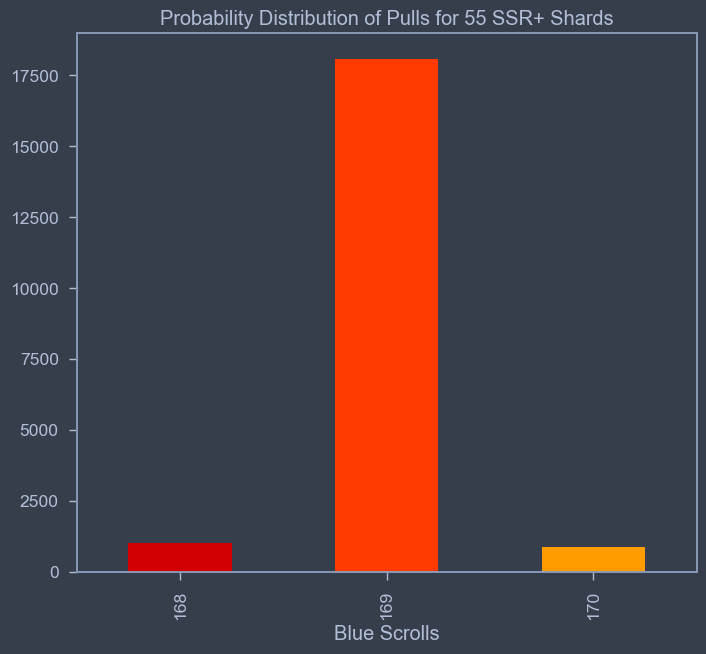

   Blue Scrolls  Likelihood
0           168        1021
1           169       18086
2           170         893
Iterations: 20000
Min:  168 blues
Max:  170 blues
Mean: 168.9936 blues
Mode: 169 blues


In [15]:
# Blues for 55 shards (0 star)
blues(55)

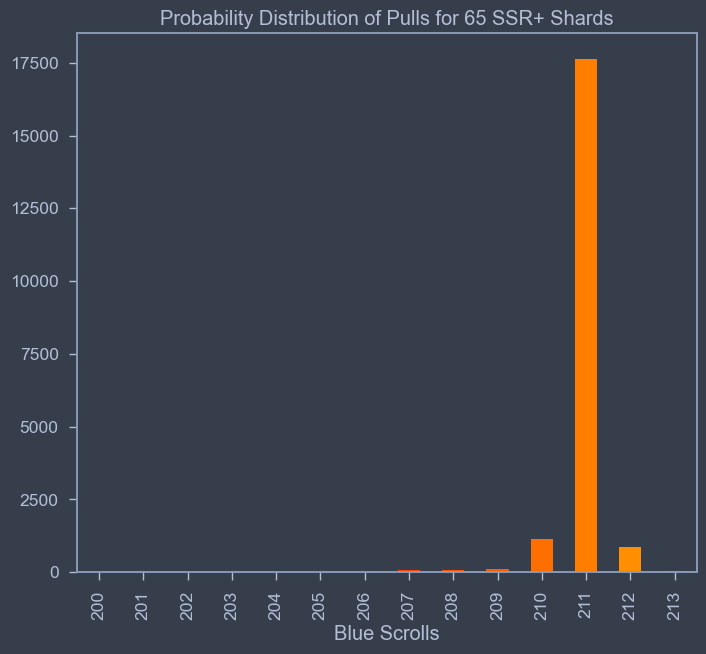

    Blue Scrolls  Likelihood
0            200           1
1            201           1
2            202           3
3            203           5
4            204           1
5            205           6
6            206          50
7            207          80
8            208          73
9            209         120
10           210        1127
11           211       17635
12           212         867
13           213          31
Iterations: 20000
Min:  200 blues
Max:  213 blues
Mean: 210.9321 blues
Mode: 211 blues


In [16]:
# Blues for 65 shards (1 star)
blues(65)

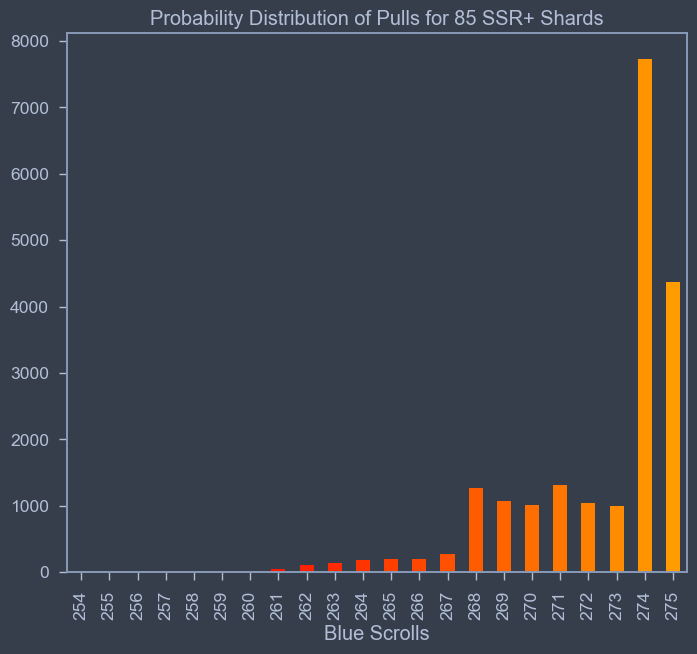

    Blue Scrolls  Likelihood
0            254           3
1            255           3
2            256           5
3            257          12
4            258           3
5            259          10
6            260          14
7            261          46
8            262         111
9            263         133
10           264         181
11           265         202
12           266         205
13           267         268
14           268        1271
15           269        1074
16           270        1007
17           271        1309
18           272        1036
19           273         999
20           274        7733
21           275        4375
Iterations: 20000
Min:  254 blues
Max:  275 blues
Mean: 272.45055 blues
Mode: 274 blues


In [17]:
# Blues for 85 shards (2 star)
blues(85)

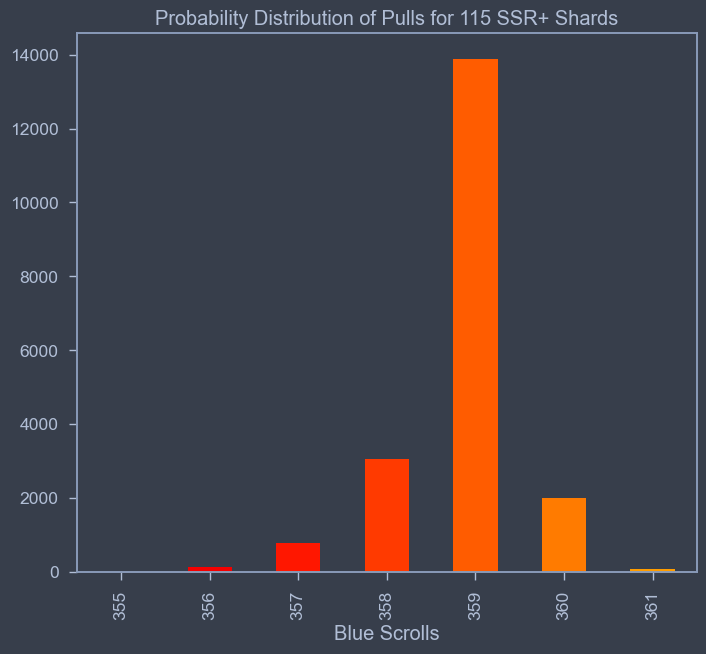

   Blue Scrolls  Likelihood
0           355          17
1           356         134
2           357         791
3           358        3068
4           359       13887
5           360        2014
6           361          89
Iterations: 20000
Min:  355 blues
Max:  361 blues
Mean: 358.8536 blues
Mode: 359 blues


In [18]:
# Blues for 115 shards (3 star)
blues(115)

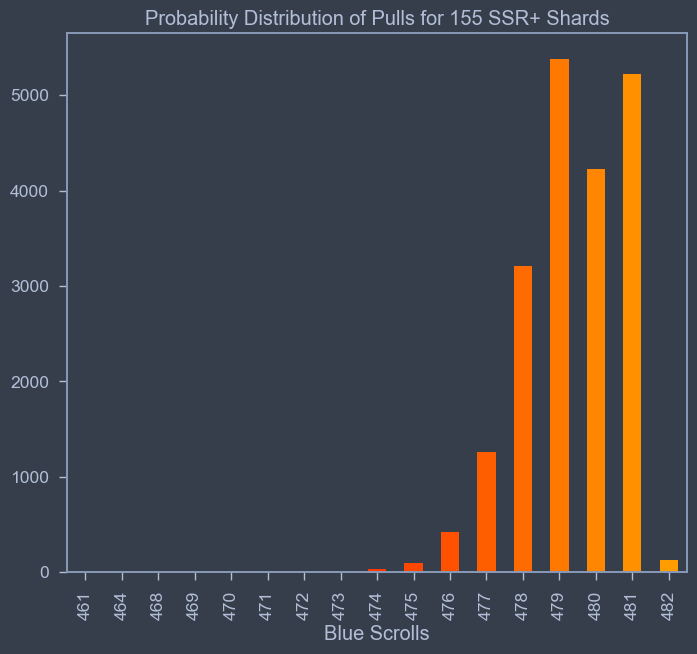

    Blue Scrolls  Likelihood
0            461           2
1            464           1
2            468           1
3            469           2
4            470           1
5            471           5
6            472           4
7            473           6
8            474          32
9            475          96
10           476         418
11           477        1263
12           478        3213
13           479        5381
14           480        4223
15           481        5223
16           482         129
Iterations: 20000
Min:  461 blues
Max:  482 blues
Mean: 479.3662 blues
Mode: 479 blues


In [19]:
# Blues for 155 shards (4 star)
blues(155)

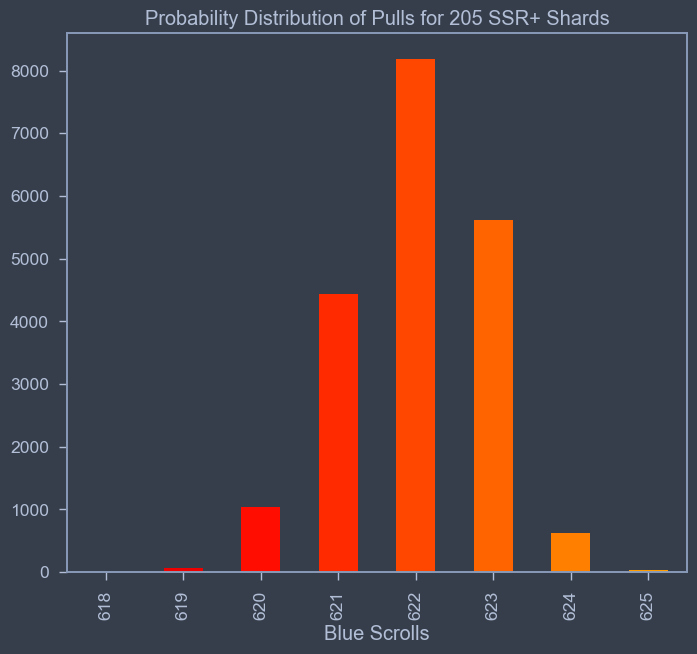

   Blue Scrolls  Likelihood
0           618           4
1           619          71
2           620        1040
3           621        4429
4           622        8188
5           623        5611
6           624         618
7           625          39
Iterations: 20000
Min:  618 blues
Max:  625 blues
Mean: 622.0113 blues
Mode: 622 blues


In [20]:
# Blues for 205 shards (5 star)
blues(205)

[*Back to Top*](#2)